# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**: Bailey Belinger

**ID**: 5277347, bcb87

> **Due Date**
>
> Wednesday, 9/25/24, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [27]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/bee4750/labs/lab2-bcb87`


In [28]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Overview

In this lab, we will use Monte Carlo analysis to analyze a version of
the culmination of every episode of the long-running game show [The
Price Is Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

In [29]:
Random.seed!(1)

TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [30]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 4
 3
 2
 ⋮
 2
 3
 3
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

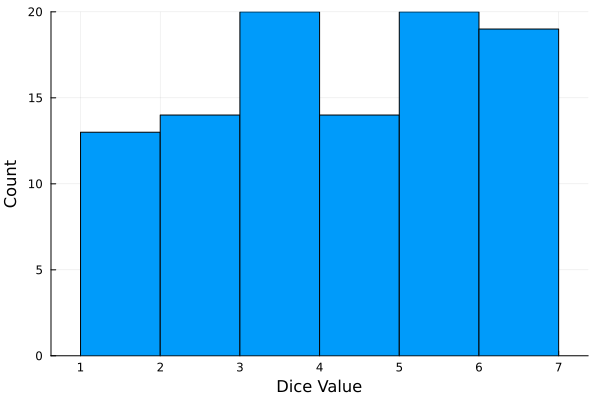

In [31]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

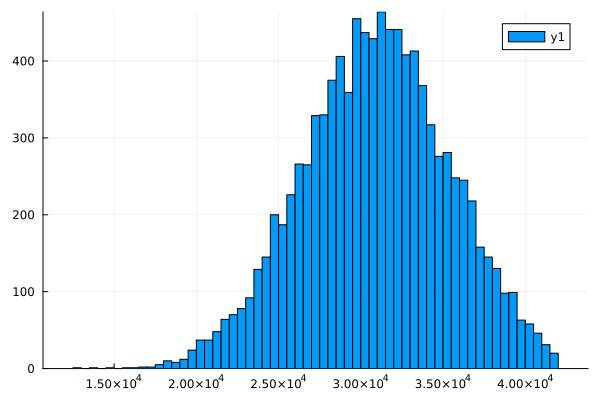

In [32]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10_000)
histogram(showcase_samples)

Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

6916.548609690512

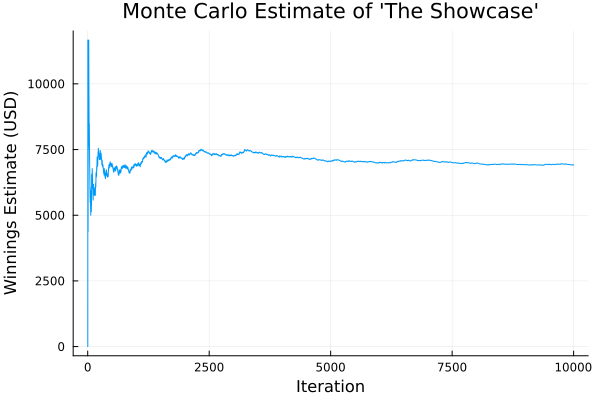

In [77]:
# The function 'sim_showcase' determines how much is 
# won based on your bid and the actual value
function sim_showcase(bid, actual)
    # Setting up the threee possibilities of winning
    if bid > actual # Overbid
        win = 0
        return win
    elseif actual-bid <= 250 # Bid within $250
        win = 2 * actual
        return win
    else # Use probability of winning to estimate what is won
        prob_win = 1-(actual - bid)/actual
        win = actual * (prob_win)
        return win
    end
end

 # Initialize vectors that will be used
winnings = zeros(10000)

# Loop through the simulation 10,000 times, sampling 
# a random value from showcase_dist each time
# Then, compare this value to your bid using the sim_showcase function
for x = 1:10000
    sample = rand(showcase_dist)
    winnings[x] = sim_showcase(35000,sample)
end

# Find the expecteding winnings and plot this 
# as a function of the iterations
exp_winnings = mean(winnings)
display(exp_winnings)
run_est = cumsum(winnings)./(1:10000)
plot(n,run_est, xlabel = "Iteration", ylabel = "Winnings Estimate (USD)", 
    title = "Monte Carlo Estimate of 'The Showcase'", legend = false)

## Discussion

The function `sim_showcase` determines the winnings based on the givien probabilities. The first section of the if statement is if you over bid, resulting in an automatic loss. The second section of the if statment determines if your bid is within the $250 range for the win of both showcases, or double of the actual value. The third section of the if statement calculate the probability of winning if you don't overbid. This probability of winning is 1 minus the probability of losing which is the difference between actual worth and the bid, divided by the actual worth. After each case, the expected amouunt you would win is returned.

To use this function, we first initialize a vector for the values of the winnings to be stored in. Then using a for loop, we iterated through the simulation 10,000 times. Each time we take a random sample from the `showcase_dist`and compare it to our bid of $35,000 using `sim_showcase` to determine the winnings from that iteration. 

To find the expected winnings, we take the mean of the 'winnings' vector which stored the expected winning from each iteration. For this specific simuation, the exptected winnings is $6,916.

To plot the running estimate, we find the cumulative sum of the 'winnings' vector and divide it by the current iteration. This finds the estimated winning or mean of each iteration.

I used 10,000 iterations because it is a signicantly large number, therefore I expected my simulation to converge within the 10,000 iterations. Based on the graph, any value greater than approximately 3,000 would have been a good stopping point becuase from there on it the graph has converged. 

**Note:**

Please see my GitHub for units on the graph. When I convert to a PDF it deletes them. Sorry for the inconvience!

## References

Camila Monter (cm755), Priya Shah (ps742)

